In [87]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

In [88]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [89]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [90]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

In [91]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


In [92]:
def closest_word_to(target_word):
    target_vector = glove.vectors[glove.stoi[target_word]].reshape(1, -1)
    max_value = 0
    max_word = None
    for word in glove.stoi:
        if word == target_word: # skip the target word
            continue
        similarity = np.abs(torch.cosine_similarity(target_vector, glove.vectors[glove.stoi[word]].reshape(1, -1)).item())
        if max_value < similarity:
            max_value = similarity
            max_word = word
    return max_word, max_value

print(closest_word_to("cat"))


('dog', 0.6816746592521667)


Comme on peut le constater le mot le plus proche de 'cat' est 'dog' avec une valeur d'environ 0.68.

In [93]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (C:/Users/theot/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 10.80it/s]
Loading cached split indices for dataset at C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-5f37fd0866e4f89f.arrow and C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [94]:
tokenizer = get_tokenizer("basic_english", language="en")

In [95]:
def lowercase_punctuation(text):
    newtext = text.lower()
    # remove <br /> tags
    newtext = newtext.replace('<br />', '')
    # remove punctuation
    newtext = ''.join([c if c not in "\"#$%&()*+,./:;<=>?@[\]^_`{|}~" else ' ' for c in newtext])
    return newtext

def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    text = lowercase_punctuation(text)
    matrix_vectors = []
    for token in tokenizer(text):
        if token in vocabulary.stoi:
            vector = vocabulary.vectors[vocabulary.stoi[token]].reshape(1, -1)
            matrix_vectors.append(vector)
    if len(matrix_vectors) == 0:
        return torch.zeros(1, 300)
    return torch.mean(torch.cat(matrix_vectors), dim=0)

In [96]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

In [97]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [01:25<00:00, 292.11it/s]


In [98]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    # Your code
    # yield the the returning values
    for i in range(0, len(X), batch_size):
        yield torch.stack(X[i:i+batch_size]), torch.tensor(y[i:i+batch_size])

In [99]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

In [100]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        # your code
        super(SimpleClassifer, self).__init__()
        self.linear = nn.Linear(embedding_size, nb_classes)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        # your code
        return self.linear(x)
        

In [101]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [102]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

In [103]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [104]:
nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()
    # training loop
    train_loss = 0.0
    for X, y in train_gen():
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y.float().reshape(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_df)
    train_losses.append(train_loss)
    
    # validation
    model.eval()
    # validation loop
    valid_loss = 0.0
    with torch.no_grad():
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y.float().reshape(-1, 1))
            valid_loss += loss.item()
        valid_loss /= len(valid_df)
        valid_losses.append(valid_loss)
    
    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss
        best_model = deepcopy(model)
        

100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


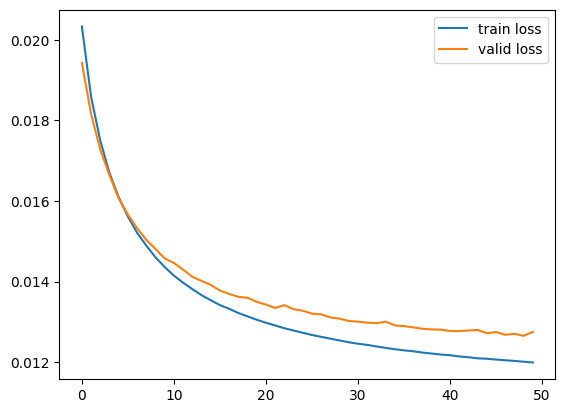

In [105]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

On peut voir une belle courbe d'apprentissage avec une train loss qui converge bien vers le bas. On pourrait croire qu'il y a un leger sur-apprentissage car la validation loss est un peu plus haute mais compte tenu de l'echelle tout va bien comme on peut le voir sur l'output suivant.

In [106]:
model = best_model
model.eval()
with torch.no_grad():
        correct = 0
        for X, y in test_gen():
            X, y = X.to(device), y.to(device)
            logits = model(X)
            y_pred = torch.round(torch.sigmoid(logits))
            correct += (y_pred == y.float().reshape(-1, 1)).sum().item()
        test_accuracy = correct / len(test_df)

print(f"Training accuracy: {1 - train_losses[-1]}")
print(f"Validation accuracy: {1 - valid_losses[-1]}")
print(f"Test accuracy: {test_accuracy}")


Training accuracy: 0.9880105470374226
Validation accuracy: 0.9872501214802265
Test accuracy: 0.82824


L'accuracy de train et l'accuracy d'apprentissage sont tres bon mais l'accuracy de test l'est moins. Peut etre que la faible variete du set de validation cache un sur-apprentissage.

In [110]:
#find two wrong predictions
model = best_model
i = 0
model.eval()
with torch.no_grad():
    for elem in test_df:
        X = vectorize_text(elem["text"], glove, tokenizer)
        X = X.to(device)
        logits = model(X)
        score = torch.sigmoid(logits)
        y_pred = torch.round(torch.sigmoid(logits)).item()
        if y_pred != elem["label"]:
            print(elem["text"])
            print(f"Expected: {elem['label']}, predicted: {y_pred}, score: {score.item()}")
            i += 1
            if i == 2:
                break

First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!
Expected: 0, predicted: 1.0, score: 0.5429120063781738
Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passion for the genre and his films are always event

La deuxieme phrase est assez speciale car il y a beaucoup de mots positif : "best" "classics" "passion" "eventful" "talented" etc.. mais l'auteur finir par dire que malgre tout cela le film n'est pas bon. C'est donc le manque de contexte qui a enduit le model en erreur, c'est similaire aux TP d'avant. On peut egalement constater que le model etait sur a 82% de lui vu le nombre de mots positifs.

Dans la premiere phrase l'auteur nous informe que le film n'est pas top mais qu'il vaut le coup d'etre vu. Ce n'est donc pas un avis tres tranche mais on y trouve egalement un champ lexical plutot positif mais avec beaucoup de "not" et la presence du mot "Hell" sortie de son contexte. Il est interessant de voir que le model a ete sur de lui a 54% sur cette phrase.

In [111]:
import fasttext

In [112]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]

Found cached dataset imdb (C:/Users/theot/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 124.00it/s]
Loading cached split indices for dataset at C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-5f37fd0866e4f89f.arrow and C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-dd5732a0e6ac784c.arrow


In [113]:
# Convert trianing and validation data to fasttext format

#shuffle the data
train_df = train_df.shuffle(seed=42)
valid_df = valid_df.shuffle(seed=42)
test_df = test_df.shuffle(seed=42)

#generate train file
with open("train.txt", "w", encoding="utf-8") as f:
    for elem in train_df:
        text = lowercase_punctuation(elem["text"])  #preprocess the text
        f.write(f"__label__{elem['label']} {text}\n")

#generate valid file
with open("valid.txt", "w", encoding="utf-8") as f:
    for elem in valid_df:
        text = lowercase_punctuation(elem["text"])  #preprocess the text
        f.write(f"__label__{elem['label']} {text}\n")

#generate test file
with open("test.txt", "w", encoding="utf-8") as f:
    for elem in test_df:
        text = lowercase_punctuation(elem["text"])  #preprocess the text
        f.write(f"__label__{elem['label']} {text}\n")

Loading cached shuffled indices for dataset at C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-1646f8e39e83ca42.arrow
Loading cached shuffled indices for dataset at C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-2b5fa46213387c00.arrow
Loading cached shuffled indices for dataset at C:\Users\theot\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-c1eaa46e94dfbfd3.arrow


In [114]:
# Train a model without validation
model = fasttext.supervised("train.txt", "model")

# Test the model
result = model.test("test.txt")

In [115]:
print(f"Test accuracy: {result.precision}")

Test accuracy: 0.86916


Les resultas sont meilleurs qu'avec notre classifier 0.869 contre 0.828 sur un meme set de test.

In [64]:
#train model with hyper parameters
model = fasttext.train_supervised(
    input="train.txt",
    autotuneValidationFile="valid.txt",
    autotuneDuration=300,
)

# Test the model
result = model.test("test.txt")
print(f"Test accuracy: {result.precision}")

AttributeError: module 'fasttext' has no attribute 'train_supervised'

Nous n'avons malheuresent pas pu installer fasttext sur notre machine mais seulement fasttext_win. Donc la fonction train_supervised() n'est pas reconnue et elle est necessaire si nous voulons donner un set de validation.

Cependant, on va quand meme essayer de prendre 2 exemples qui ont enduit notre premier modele en erreur.

In [85]:
text = "Very good movie, I recommend it."
text = lowercase_punctuation(text)
print(text)
print(model.predict(text))

text = "Very bad movie, I don't recommend it."
text = lowercase_punctuation(text)
print(text)
print(model.predict(text))

very good movie  i recommend it 
[['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0']]
very bad movie  i don't recommend it 
[['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0']]


Nous ne savons pas comment interpreter ces tableaux pour de simples phrases donc nous avons abandonne cette partie aussi.